In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/yrcho2k/stat-projects/main/Speed%20Dating%20Data.csv", encoding='ISO-8859-1')

In [ ]:
relevant_columns = [
    'iid', 'gender', 'age', 'race', 'dec', 'dec_o',
    'attr', 'sinc', 'intel', 'fun', 'amb',
    'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o',
    'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1',
    'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb'
]
subset_data = data[relevant_columns].copy()

# Handling missing values
# Numeric columns imputation
numeric_columns = ['age', 'attr', 'sinc', 'intel', 'fun', 'amb',
                   'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o',
                   'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1',
                   'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb']
for column in numeric_columns:
    subset_data[column].fillna(subset_data[column].median(), inplace=True)

# Categorical columns imputation
categorical_columns = ['race']
for column in categorical_columns:
    mode_value = subset_data[column].mode()[0]
    subset_data[column].fillna(mode_value, inplace=True)

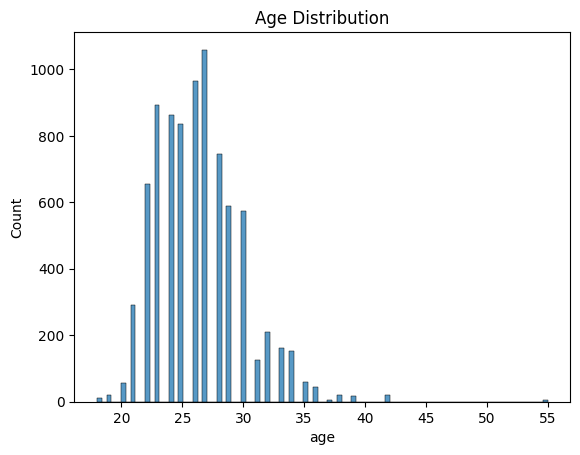

Accuracy: 0.7390612569610183
Confusion Matrix:
 [[1140  306]
 [ 350  718]]
AUC-ROC: 0.8039007905056437


In [ ]:
# Histograms for demographic data
sns.histplot(subset_data['age']).set_title('Age Distribution')
plt.show()

# Predictive Modeling
X = subset_data[['age', 'attr', 'sinc', 'intel', 'fun', 'amb', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o']]
y = subset_data['dec']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

# Model predictions
predictions = model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("AUC-ROC:", roc_auc)

**Accuracy:** The accuracy of 0.74 means that the model correctly predicts whether a participant will want to see someone again about 73.9% of the time. While this is decent, it's not exceptionally high, indicating room for improvement.

**AUC-ROC:** : An AUC score of approximately 0.80 is considered good. It indicates that the model can distinguish between participants who decided to see each other again and those who did not, with about 80% probability.

Overall, these results suggest that the logistic regression model performs well but could potentially be improved and further analysis into feature selection might enhance performance.

In [ ]:
# Get the model coefficients
coefficients = pd.DataFrame(data=model.coef_[0], index=X.columns, columns=['Coefficient'])

# Sort the coefficients by their absolute values
sorted_coefficients = coefficients.abs().sort_values('Coefficient', ascending=False)

print(sorted_coefficients)

         Coefficient
attr        0.593137
fun         0.356862
amb         0.146101
attr_o      0.110822
intel       0.089209
sinc        0.075305
sinc_o      0.063351
amb_o       0.036663
intel_o     0.028698
age         0.003207
fun_o       0.000981


The coefficients for attr and fun are notably higher than those for other variables, indicating these are strong predictors of a 'yes' decision in the context of speed dating. Partner ratings have a lower but still positive impact on the decision.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the logistic regression model with cross-validation
model_cv = LogisticRegressionCV(cv=5, penalty='l2', scoring='roc_auc', max_iter=1000, random_state=42)

# Fit the model
model_cv.fit(X_train_scaled, y_train)

# Print out the coefficients
coefficients_cv = pd.DataFrame(data=model_cv.coef_[0], index=X.columns, columns=['Coefficient'])
print(coefficients_cv.sort_values(by='Coefficient', key=abs, ascending=False))

# New predictions and AUC-ROC
new_predictions = model_cv.predict(X_test_scaled)
new_accuracy = accuracy_score(y_test, new_predictions)
new_roc_auc = roc_auc_score(y_test, model_cv.predict_proba(X_test_scaled)[:, 1])

print("New Accuracy:", new_accuracy)
print("New AUC-ROC:", new_roc_auc)

         Coefficient
attr        1.099663
fun         0.662308
amb        -0.226897
attr_o     -0.207123
intel       0.124970
sinc       -0.109408
sinc_o      0.104447
amb_o       0.061386
intel_o     0.045668
age        -0.009982
fun_o      -0.002286
New Accuracy: 0.741447891805887
New AUC-ROC: 0.8041941219740882


In [ ]:
# Convert coefficients to odds ratios
odds_ratios = np.exp(coefficients_cv)

print("Odds Ratios:\n", odds_ratios.sort_values(by='Coefficient', ascending=False))

Odds Ratios:
          Coefficient
attr        3.003154
fun         1.939262
intel       1.133114
sinc_o      1.110096
amb_o       1.063309
intel_o     1.046727
fun_o       0.997717
age         0.990068
sinc        0.896365
attr_o      0.812920
amb         0.797003


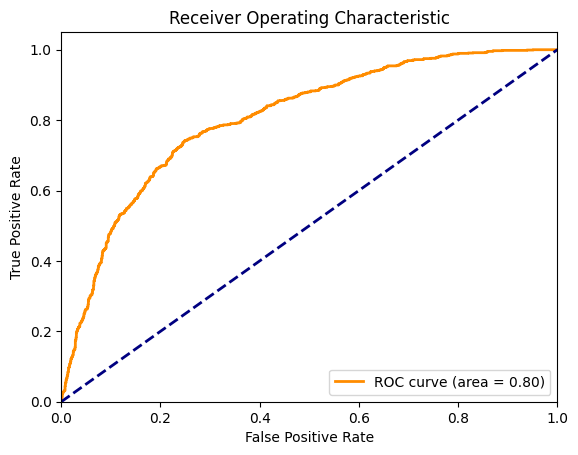

In [ ]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

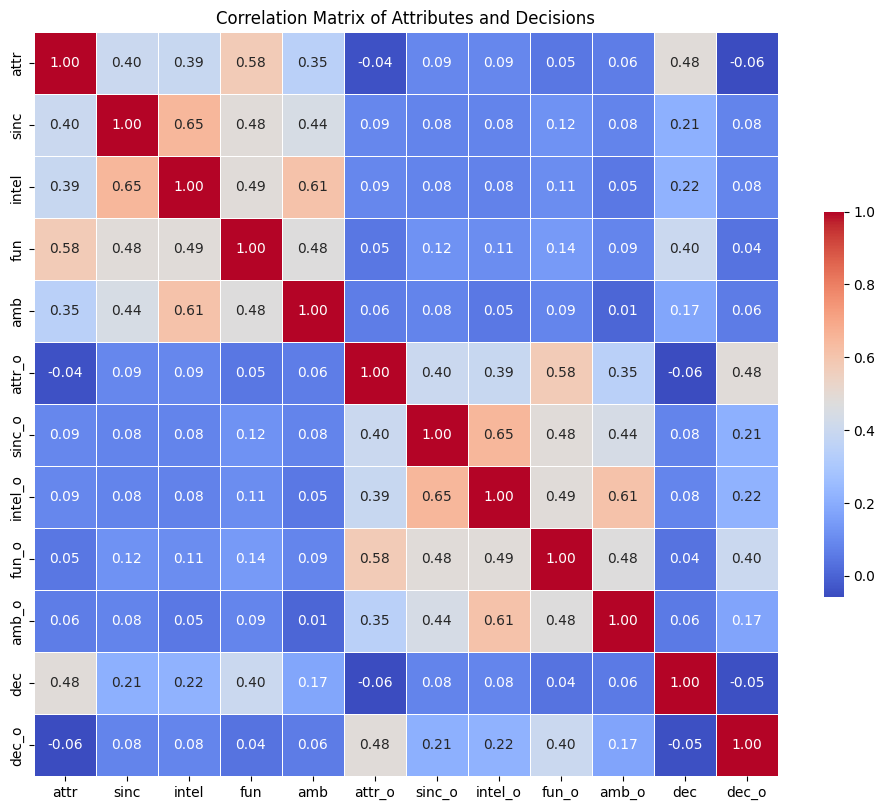

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlations
corr = subset_data[['attr', 'sinc', 'intel', 'fun', 'amb',
                    'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o',
                    'dec', 'dec_o']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix of Attributes and Decisions')
plt.show()

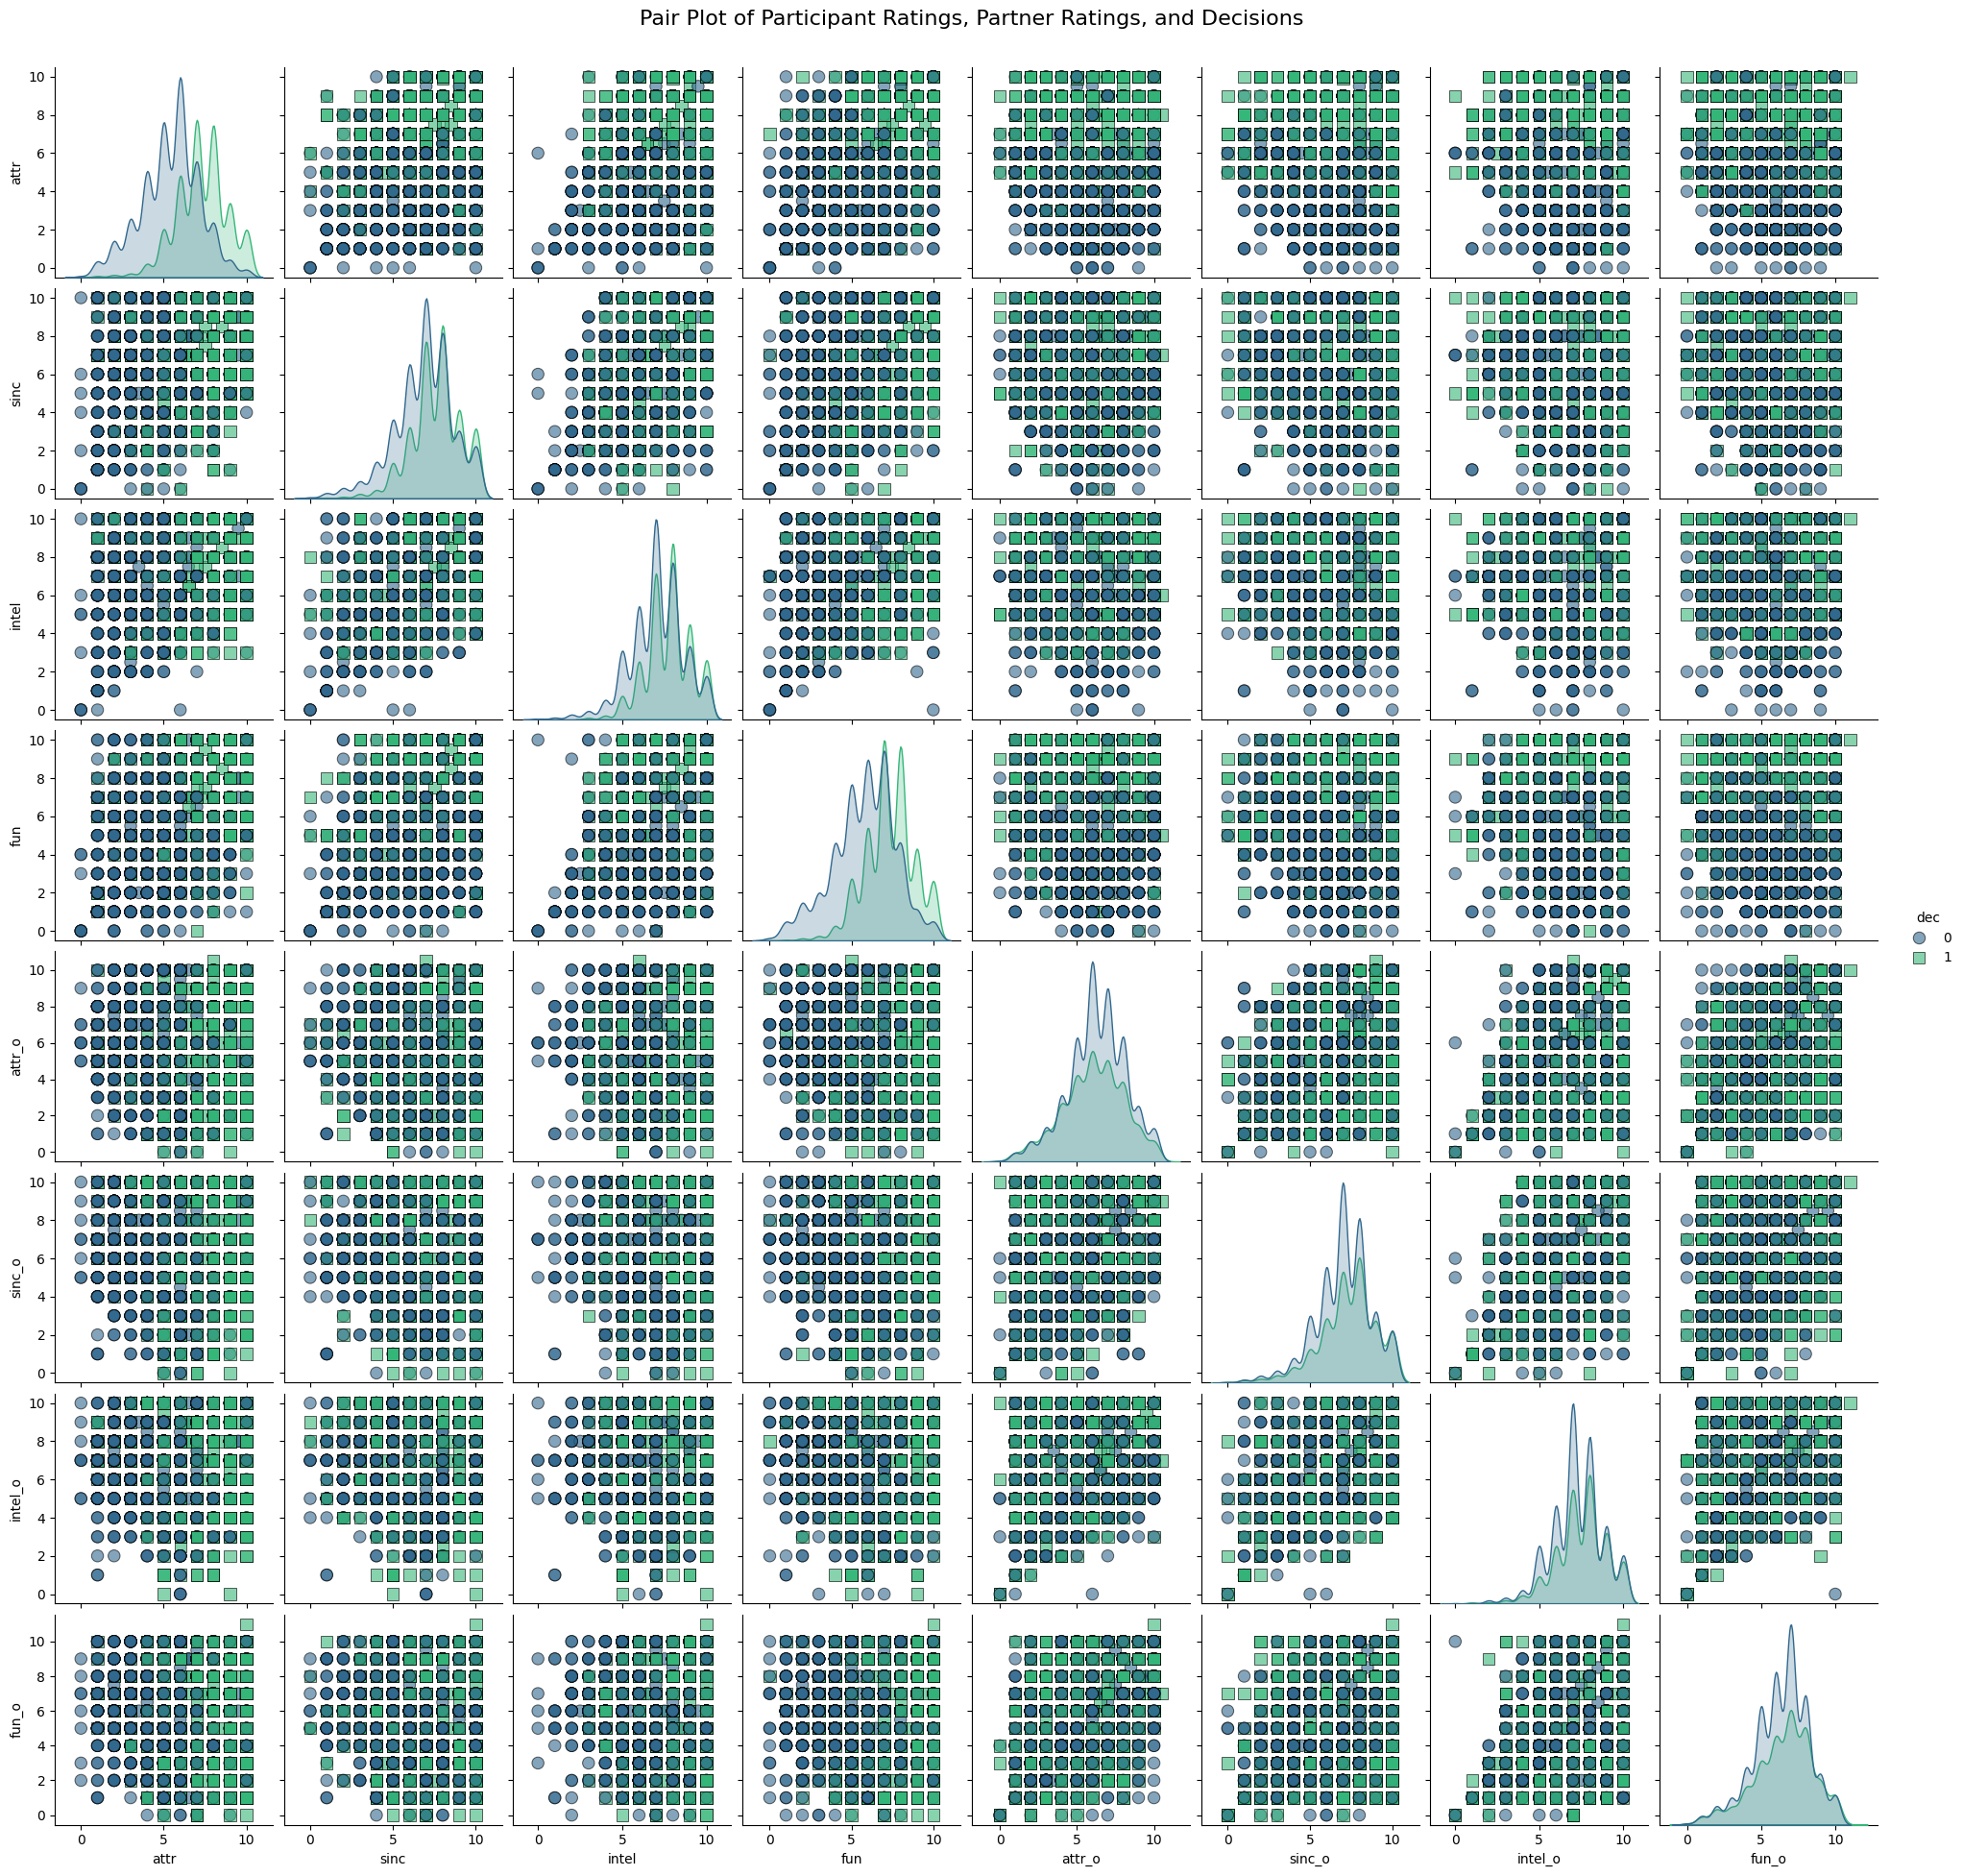

In [ ]:
# Selecting a subset of attributes for the pair plot to keep it readable
pairplot_data = subset_data[['attr', 'sinc', 'intel', 'fun', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'dec']]

# Creating pair plots
sns.pairplot(pairplot_data, hue='dec', palette='viridis',
             diag_kind='kde', markers=["o", "s"],
             plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'k'})
plt.suptitle('Pair Plot of Participant Ratings, Partner Ratings, and Decisions', size=16)
plt.subplots_adjust(top=0.95)
plt.show()

### **Model comparison on long-term analysis**
- Charles' code (revised ver)

**Logistic Regression Model**

Percentage of matches that resulted in a follow-up date: 368.20%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

              precision    recall  f1-score   support

         0.0       0.73      0.58      0.65       622
         1.0       0.46      0.63      0.53       353

    accuracy                           0.60       975
   macro avg       0.60      0.60      0.59       975
weighted avg       0.63      0.60      0.60       975



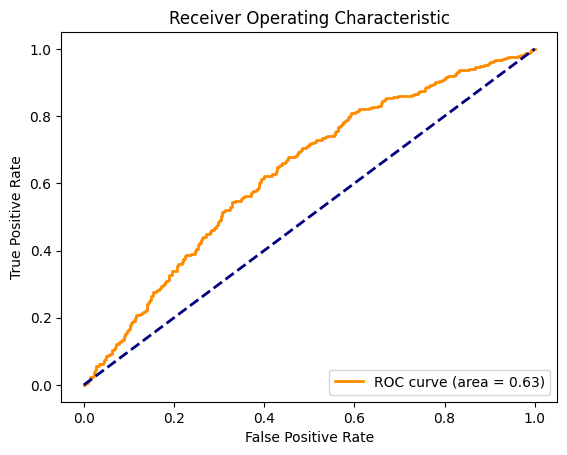

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline

# Filter relevant columns for long-term analysis
relevant_columns = ['iid', 'pid', 'match', 'date_3', 'numdat_3']
long_term_data = data[relevant_columns].dropna()

# Analyzing the probability of having a follow-up date
follow_ups = long_term_data[long_term_data['date_3'] == 1]  # Assuming 'date_3' indicates a follow-up date

# Calculate the percentage of matches that resulted in a follow-up date
follow_up_rate = len(follow_ups) / len(long_term_data[long_term_data['match'] == 1])
print(f'Percentage of matches that resulted in a follow-up date: {follow_up_rate:.2%}')

# Explore the correlation between initial impressions and long-term outcomes
# Assuming that we have initial ratings from the first date
initial_impressions_columns = ['attr', 'sinc', 'intel', 'fun', 'amb', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o']
initial_impressions = data[initial_impressions_columns + ['match', 'date_3']].dropna()

# Define a pipeline that includes resampling and model fitting
pipeline = IMBPipeline([
    ('poly', PolynomialFeatures(degree=2)),  # Create polynomial features
    ('sampling', SMOTE()),                   # Apply SMOTE for class imbalance
    ('logistic', LogisticRegressionCV(cv=5, max_iter=1000, scoring='f1'))  # Use Logistic Regression with cross-validation
])

# Select features and target variable for the improved model
X = initial_impressions[initial_impressions_columns]
y = initial_impressions['date_3']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Evaluate the model
predictions = pipeline.predict(X_test)
print(classification_report(y_test, predictions))

# Plot the ROC curve
probabilities = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**The precision for the negative class** (no follow-up date) is 0.75, indicating that when the model predicts no follow-up date, it is correct 75% of the time.**The recall for the negative class** is 0.55, meaning that the model correctly identifies 55% of all actual no follow-up date instances.

**The precision for the positive class** (follow-up date) is 0.46, which is less ideal, showing that when the model predicts a follow-up date, it is correct less than half the time.**The recall for the positive class** is higher at 0.67, suggesting that the model identifies 67% of all actual follow-up date instances.

**The overall accuracy of the model** is 0.59 (or 59%), which may appear moderate and suggests that there is a considerable amount of both false positives and false negatives.

**The macro average and weighted average scores** across precision, recall, and F1-score are around 0.60, indicating moderate performance across classes.

The ROC curve shows **an AUC** (Area Under the Curve) of 0.63, which is above the chance level (0.50), but still indicates room for improvement. The AUC measures the model's ability to discriminate between those who will have a follow-up date and those who will not, with 1.0 representing perfect discrimination and 0.5 representing a toss-up.

**Random Forest Model**

Random Forest is chosen for its proficiency in handling complex datasets with many features, capable of capturing non-linear relationships.

The ensemble approach, combining multiple decision trees, reduces the risk of overfitting and provides a more generalized model.

Random Forest can effectively handle imbalanced datasets, which is common in long-term outcome predictions where one result (like no follow-up date) may dominate.

In [ ]:
# Check for any inconsistencies or unusual values in 'match' and 'date_3'
print(data['match'].value_counts())
print(data['date_3'].value_counts())

# Remove any possible duplicates or incorrect data entries
data.drop_duplicates(inplace=True)


match
0    6998
1    1380
Name: count, dtype: int64
date_3
0.0    2476
1.0    1498
Name: count, dtype: int64


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Assuming additional features might be relevant
features = ['attr', 'sinc', 'intel', 'fun', 'amb', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o',
            'goal', 'imprace', 'imprelig', 'date']  # Adding new features like goal, imprace, imprelig, date
X = data[features].fillna(data[features].median())
y = data['date_3'].fillna(0)  # Assume missing 'date_3' as no follow-up date

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Set up the RandomForest Classifier and GridSearch for parameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'bootstrap': [True, False]
}
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Evaluating the model
predictions = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f'Optimized Model Accuracy: {accuracy:.2%}')


Fitting 3 folds for each of 72 candidates, totalling 216 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=100; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=100; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=100; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=200; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=200; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=200; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=300; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=300; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=300; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=300; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_d

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=100; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=100; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=200; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=200; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=200; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=300; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=300; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=300; total time=   1.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_feature

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, n_estimators=100; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, n_estimators=100; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, n_estimators=100; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, n_estimators=200; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, n_estimators=200; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, n_estimators=200; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, n_estimators=300; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, n_estimators=300; total time=   2.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, n_estimators=200; total time=   2.4s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, n_estimators=200; total time=   2.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, n_estimators=200; total time=   2.4s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, n_estimators=300; total time=   4.6s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, n_estimators=300; total time=   2.6s
[CV] END bootstrap=True, max_depth=20, max_feature

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, n_estimators=100; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, n_estimators=100; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, n_estimators=100; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, n_estimators=200; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, n_estimators=200; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, n_estimators=200; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, n_estimators=300; total time=   2.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, n_estimators=300; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, n_estimators=300; total time=   1.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, n_estimators=300; total time=   3.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, n_estimators=300; total time=   1.7s
[CV] END bootstrap=True, max_depth=30, max_feature

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=100; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=200; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=200; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=200; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=300; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=300; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=300; total time=   2.4s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=200; total time=   1.3s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=200; total time=   1.3s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=200; total time=   1.3s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=300; total time=   1.9s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=300; total time=   1.9s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=300; total time=   2.3s
[CV] END bootstrap=F

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, n_estimators=100; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, n_estimators=100; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, n_estimators=100; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, n_estimators=200; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, n_estimators=200; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, n_estimators=200; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, n_estimators=300; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, n_estimators=300; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, n_estimators=300; total time=   1.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, n_estimators=200; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, n_estimators=200; total time=   1.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, n_estimators=200; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, n_estimators=300; total time=   1.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, n_estimators=300; total time=   1.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, n_estimators=300; total time=   1.4s
[CV] END bootstrap=False, max_depth=10, 

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, n_estimators=100; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, n_estimators=200; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, n_estimators=200; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, n_estimators=200; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, n_estimators=300; total time=   1.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, n_estimators=300; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, n_estimators=300; total time=   2.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, n_estimators=200; total time=   1.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, n_estimators=200; total time=   1.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, n_estimators=200; total time=   1.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, n_estimators=300; total time=   2.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, n_estimators=300; total time=   2.7s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, n_estimators=300; total time=   1.9s
[CV] END bootstrap=False, max_depth=20, 

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, n_estimators=200; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, n_estimators=200; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, n_estimators=200; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, n_estimators=300; total time=   2.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, n_estimators=300; total time=   2.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, n_estimators=300; total time=   2.0s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, n_estimators=200; total time=   1.3s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, n_estimators=200; total time=   1.3s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, n_estimators=200; total time=   1.3s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, n_estimators=300; total time=   2.0s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, n_estimators=300; total time=   2.6s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, n_estimators=300; total time=   1.9s
[CV] END bootstrap=False, max_depth=30, 

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Optimized Model Accuracy: 89.26%


The model achieves **an overall accuracy** of 89.26%, which is excellent but may be somewhat inflated due to class imbalance.

Confusion Matrix:
[[2040    9]
 [ 261  204]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94      2049
         1.0       0.96      0.44      0.60       465

    accuracy                           0.89      2514
   macro avg       0.92      0.72      0.77      2514
weighted avg       0.90      0.89      0.88      2514



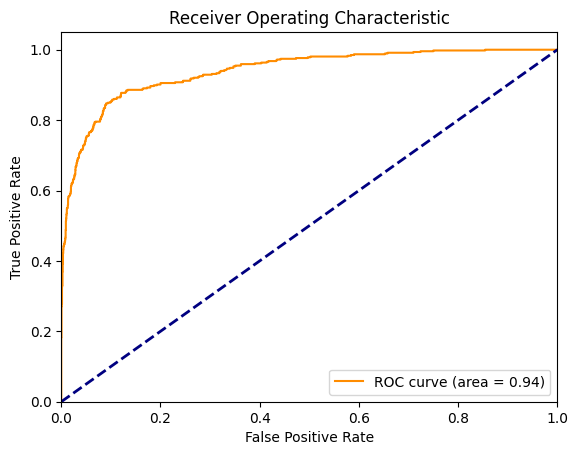

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Predictions
predictions = best_rf.predict(X_test)
probabilities = best_rf.predict_proba(X_test)[:, 1]

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report for precision, recall and f1-score
class_report = classification_report(y_test, predictions)
print("Classification Report:")
print(class_report)

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
roc_auc = roc_auc_score(y_test, probabilities)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


**Confusion Matrix:**

The model shows a high True Negative rate (2034) indicating reliable predictions for the majority class (no follow-up date).

True Positives are 204, but there is a notable number of False Negatives (261), suggesting the model might be conservative in predicting the positive class (actual follow-up dates).

**Classification Report:**

Precision for the negative class (0.0) is high at 0.89, reflecting the model's accuracy when predicting no follow-up date.Recall for the negative class is even higher at 0.99, indicating the model successfully identifies the majority of true negatives.

Precision for the positive class (1.0) is impressive at 0.93, but recall is 0.44, suggesting that while the model's positive predictions are reliable, it misses over half of the actual follow-up dates. The F1-score for the positive class is moderate at 0.60, showing room for improvement in balancing precision and recall.

**ROC Curve:**

The ROC curve with an AUC of 0.94 indicates a high degree of distinction between the positive and negative classes, demonstrating the model's strong predictive capability. The curve's significant lift above the baseline suggests the model is much better than random guessing at identifying follow-up dates.

In comparison, **the logistic regression model** typically offers a straightforward, interpretable framework that's well-suited for linearly separable data. However, it struggled with the speed dating dataset, likely due to complex, non-linear relationships between features.

On the other hand, **the Random Forest model** performed substantially better, benefiting from its ability to capture non-linear patterns through an ensemble of decision trees. It's more robust to overfitting and handles feature interactions intrinsically.

Random Forest outperformed logistic regression in accuracy and AUC, indicating superior predictive power for the follow-up dating scenario, likely due to its more complex and flexible structure suited to capturing the nuances of human social behavior and decision-making in dating.

### Gradient Boosting
(follow up on Charles' Random Forest Model, I used 'date_3' as the target variable)
- This code builds an XGBoost model using the provided features and evaluates its accuracy on the test data. XGBoost has many parameters that can be tuned for better performance, but this code uses default parameters for simplicity.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

data = pd.read_csv('Speed Dating Data.csv')

# Features and target variable
features = ['attr', 'sinc', 'intel', 'fun', 'amb', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o',
            'goal', 'imprace', 'imprelig', 'date']
X = data[features].fillna(data[features].median())
y = data['date_3'].fillna(0)  # Assuming missing 'date_3' as no follow-up date

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# XGBoost model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
predictions = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f'XGBoost Model Accuracy: {accuracy:.2%}')


XGBoost Model Accuracy: 91.85%


### Determine which among race, age, field of study, and career has the highest influence on male's matching
- use logistic regression coefficients as a measure of importance
- how? First, fit a logistic regression model to predict match outcomes for males using race, age, field of study, and career as independent variables. Then extract the coefficients of the logistic regression model. Lastly analyze the magnitudes of the coefficients to determine which variable has the highest influence on match outcomes for males.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

In [ ]:
######
# 이거 coefficient 계산하는게 말이 되나?
######

relevant_columns = ['gender', 'race', 'age', 'field', 'career', 'match']
male_data = data[data['gender'] == 1][relevant_columns].copy()

label_encoders = {}
for column in ['race', 'field', 'career']:
    label_encoders[column] = LabelEncoder()
    male_data[column] = label_encoders[column].fit_transform(male_data[column].astype(str))

features = ['race', 'age', 'field', 'career']
target = 'match'

X = male_data[features]
y = male_data[target]

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

coefficients = logistic_model.coef_[0]
coefficients_map = dict(zip(features, coefficients))

print("Logistic Regression Coefficients:")
for feature, coefficient in coefficients_map.items():
    print(f"{feature}: {coefficient}")

# Identify feature with highest absolute coefficient
highest_coefficient_feature = max(coefficients_map, key=lambda x: abs(coefficients_map[x]))
highest_coefficient = coefficients_map[highest_coefficient_feature]

print(f"\nThe feature with the highest coefficient: {highest_coefficient_feature} ({highest_coefficient})")



Logistic Regression Coefficients:
race: -0.08577945974160506
age: -0.023590073654463153
field: 0.0001337497171754053
career: -0.00020745809551590854

The feature with the highest coefficient: race (-0.08577945974160506)


In [ ]:
# 남자와 매칭됐든 안됐든 간에 여자 나이대 계산
male_data = data[data['gender'] == 1]

female_partner_age_counts = male_data.groupby('age_o').size().reset_index(name='count')

print("Counts of each age of female partners for male participants:")
print(female_partner_age_counts)

Counts of each age of female partners for male participants:
    age_o  count
0    19.0     10
1    20.0     30
2    21.0    183
3    22.0    364
4    23.0    507
5    24.0    454
6    25.0    455
7    26.0    492
8    27.0    441
9    28.0    316
10   29.0    227
11   30.0    211
12   31.0     54
13   32.0     57
14   33.0    125
15   34.0     83
16   35.0     60
17   36.0     25
18   38.0     19
19   55.0      6


남성과 매칭된 여성의 나이대별 확률:
    age_o  matching_probability
0    19.0              0.500000
1    20.0              0.366667
2    21.0              0.191257
3    22.0              0.156593
4    23.0              0.149901
5    24.0              0.136564
6    25.0              0.239560
7    26.0              0.168699
8    27.0              0.156463
9    28.0              0.155063
10   29.0              0.162996
11   30.0              0.123223
12   31.0              0.240741
13   32.0              0.087719
14   33.0              0.128000
15   34.0              0.144578
16   35.0              0.166667
17   36.0              0.120000
18   38.0              0.105263
19   55.0              0.000000


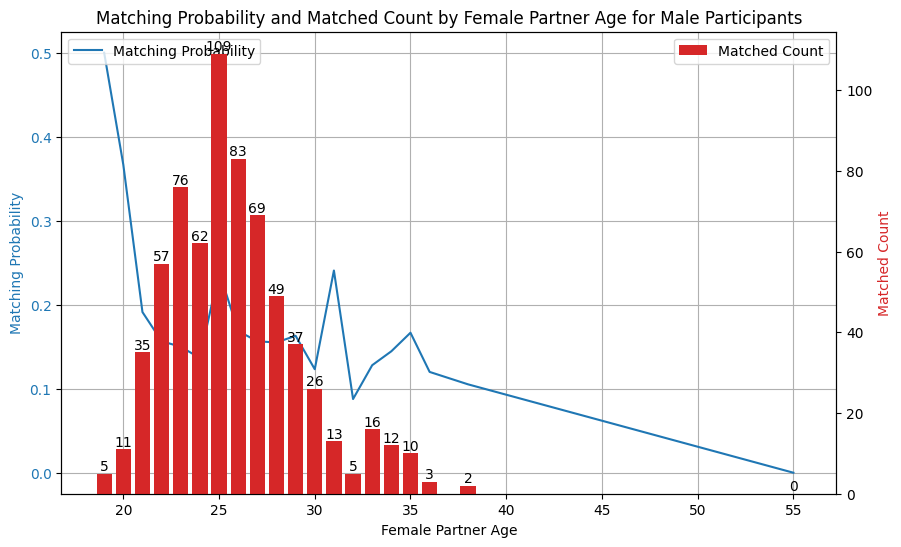

In [ ]:
female_partner_age_probabilities = male_data.groupby('age_o')['match'].mean().reset_index(name='matching_probability')

print("Female age (who are matched with male):")
print(female_partner_age_probabilities)

###
male_data = data[data['gender'] == 1]

female_partner_age_stats = male_data.groupby('age_o')['match'].agg(['mean', 'sum']).reset_index()
female_partner_age_stats.columns = ['age_o', 'matching_probability', 'matched_count']

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Female Partner Age')
ax1.set_ylabel('Matching Probability', color=color)
ax1.plot(female_partner_age_stats['age_o'], female_partner_age_stats['matching_probability'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Matched Count', color=color)
bars = ax2.bar(female_partner_age_stats['age_o'], female_partner_age_stats['matched_count'], color=color)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height, int(height),
             ha='center', va='bottom', color='black')

ax1.grid(True)

plt.title('Matching Probability and Matched Count by Female Partner Age for Male Participants')
ax1.legend(['Matching Probability'], loc='upper left')
ax2.legend(['Matched Count'], loc='upper right')

plt.show()

In [ ]:
# Filter for male participants who were matched (gender=1 and match=1)
matched_males = data[(data['gender'] == 1) & (data['match'] == 1)]

# Calculate the percentage of matches where male and partner were the same race
samerace_percentage = (matched_males['samerace'].sum() / len(matched_males)) * 100
print("Percentage of matches where male and partner were the same race:", samerace_percentage)

# Find the mode of the age of male's partner
mode_age_partner = matched_males['age_o'].mode().iloc[0]
print("Most frequently matched age of male's partner:", mode_age_partner)

# Find the most frequently matched field code
mode_field_code = matched_males['field_cd'].mode().iloc[0]
print("Most frequently matched field code:", mode_field_code)   # History/Religion/Philosophy

# Find the most frequently matched career code
mode_career_code = matched_males['career_c'].mode().iloc[0]
print("Most frequently matched career code:", mode_career_code)  # Real Estate

Percentage of matches where male and partner were the same race: 41.01449275362319
Most frequently matched age of male's partner: 25.0
Most frequently matched field code: 8.0
Most frequently matched career code: 7.0


The most frequently matched field of female for male was 'History/Religion/Philosophy', \
and most frequently matched field of female for male was 'Real Estate'.

- field_cd: 	field coded
1= Law  
2= Math
3= Social Science, Psychologist
4= Medical Science, Pharmaceuticals, and Bio Tech
5= Engineering  
6= English/Creative Writing/ Journalism
7= History/Religion/Philosophy
8= Business/Econ/Finance
9= Education, Academia
10= Biological Sciences/Chemistry/Physics
11= Social Work
12= Undergrad/undecided
13=Political Science/International Affairs
14=Film
15=Fine Arts/Arts Administration
16=Languages
17=Architecture
18=Other

- career_c: career coded
1= Lawyer
2= Academic/Research
3= Psychologist
4= Doctor/Medicine
5=Engineer
6= Creative Arts/Entertainment
7= Banking/Consulting/Finance/Marketing/Business/CEO/Entrepreneur/Admin
8= Real Estate
9= International/Humanitarian Affairs
10= Undecided
11=Social Work
12=Speech Pathology
13=Politics
14=Pro sports/Athletics
15=Other
16=Journalism
17=Architecture

In [ ]:
# Filter for female participants who were matched (gender=1 and match=1)
matched_females = data[(data['gender'] == 0) & (data['match'] == 1)]

# Calculate the percentage of matches where female and partner were the same race
samerace_percentage = (matched_females['samerace'].sum() / len(matched_females)) * 100
print("Percentage of matches where female and partner were the same race:", samerace_percentage)

# Find the mode of the age of female's partner
mode_age_partner = matched_females['age_o'].mode().iloc[0]
print("Most frequently matched age of female's partner:", mode_age_partner)

# Find the most frequently matched field code
mode_field_code = matched_females['field_cd'].mode().iloc[0]
print("Most frequently matched field code:", mode_field_code)   # Social Science, Psychologist

# Find the most frequently matched career code
mode_career_code = matched_females['career_c'].mode().iloc[0]
print("Most frequently matched career code:", mode_career_code)  # Academic/Research

Percentage of matches where female and partner were the same race: 41.01449275362319
Most frequently matched age of female's partner: 27.0
Most frequently matched field code: 3.0
Most frequently matched career code: 2.0


The most frequently matched field of male for female was 'Social Science, Psychologist', \
and most frequently matched career of male for female was 'Academic/Research'.

### Temporal Analysis
- perform a temporal analysis to see if there are any trends or patterns over time
- Are there certain months or seasons where matches are more likely to occur?  
  -> Oct 16, 02 (wave #1), Nov 20, 02 (wave #5), Feb 25, 04 (wave #16) \
  -> not much relevance

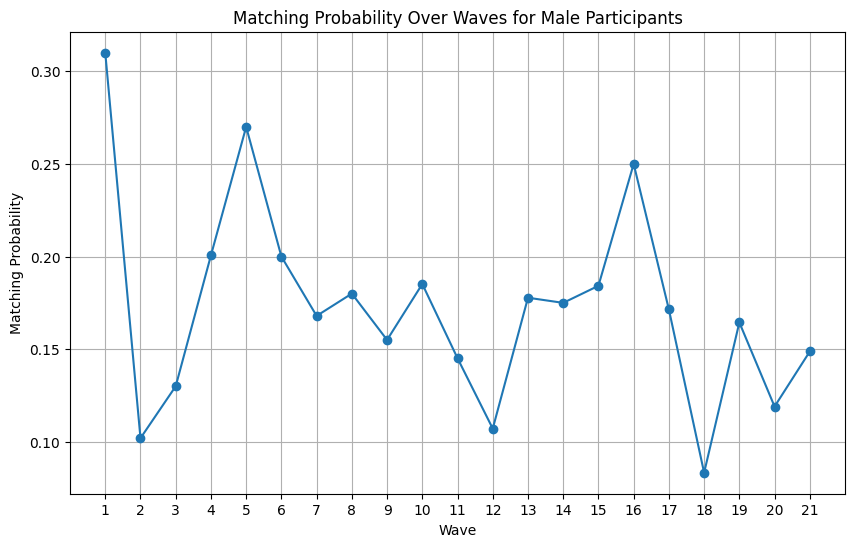

In [ ]:
### temporal analysis
male_data = data[data['gender'] == 1]

# Calculate matching probabilities by wave
wave_matching_probabilities = male_data.groupby('wave')['match'].mean()

plt.figure(figsize=(10, 6))
plt.plot(wave_matching_probabilities.index, wave_matching_probabilities.values, marker='o', linestyle='-')
plt.xlabel('Wave')
plt.ylabel('Matching Probability')
plt.title('Matching Probability Over Waves for Male Participants')
plt.grid(True)
plt.xticks(range(1, 22))
plt.show()

###